In [1]:
import pandas as pd
import numpy as np
import gwaslab as gl
import seaborn as sns
import matplotlib.pyplot as plt

gtf_path = gl.CommonData.check_and_download("ensembl_hg19_gtf")
gtf_path = '/Users/clu/.gwaslab/Homo_sapiens.GRCh37.87.chr.protein_coding.gtf.gz'
gtf_db_path = gtf_path[:-2]+"db"
from pyensembl import Genome
data = Genome(
                reference_name='GRCh37',
                annotation_name='Ensembl',
                gtf_path_or_url=gtf_path)

locus_all = pd.read_csv('/Users/clu/git/3D_cardiac_GWAS/the_paper/data/locus_all.csv', index_col=0)


In [2]:
# eQTL, summarise significant genes and plot
tissue='Heart_Left_Ventricle'
# tissue='Heart_Atrial_Appendage'
qtl='eqtl'
trait='Err'
savesig=0
plot=1

# save significant genes
if savesig == 1:
    significants = pd.DataFrame()
    for aha in range(1,17):
        # Load TWAS results
        twas = pd.read_csv(f'results/spredixcan/{qtl}/40kahat64_sexagebmibsa2bp_{trait}_AHA_{aha}_chrmerged__PM__{tissue}.csv')
        sig = twas[twas['pvalue']<0.05/twas.shape[0]]
        significants = pd.concat([significants, sig.assign(aha=aha)])
    # get the gene locations
    gene_loc = pd.read_csv(f'/Users/clu/work/tests/MetaXcan/data/models/{qtl}/mashr/mashr_{tissue}.txt.gz', delim_whitespace=True)
    gene_loc = gene_loc.drop_duplicates(subset=['GENE'])
    significants = significants.merge(gene_loc[['GENE','RSID1']], left_on='gene', right_on='GENE', how='left')
    significants.to_csv(f'results/spredixcan/{qtl}/{qtl[0]}QTL_{trait}_{tissue}.csv', index=False)


In [13]:
# eQTL, summarise significant genes and plot
tissue='Heart_Left_Ventricle'
# tissue='Heart_Atrial_Appendage'
qtl='eqtl'
trait='Err'

In [14]:
# Read all TWAS results
aha=1
twas = pd.read_csv(f'results/spredixcan/{qtl}/40kahat64_sexagebmibsa2bp_{trait}_AHA_{aha}_chrmerged__PM__{tissue}.csv')
twas.drop(columns=['pred_perf_r2',	'pred_perf_pval',	'pred_perf_qval'], inplace=True)
# add columns start,end
twas = twas.assign(chrom=pd.NA,start=pd.NA, end=pd.NA)
for i, row in twas.iterrows():
    try:
        loci = data.loci_of_gene_names(row['gene_name'])
    except:
        # print('cant find:', row['gene_name'])
        continue
    twas.loc[i,'chrom'] = loci[0].contig
    twas.loc[i,'start'] = loci[0].start
    twas.loc[i,'end'] = loci[0].end

# remove na
print(f'out of {twas.shape[0]}, cant find {twas.chrom.isna().sum()}')
twas.dropna(inplace=True)
print(f'remaining {twas.shape[0]}')

twas = twas.assign(sign_pvalue=np.sign(twas['effect_size'])*twas['pvalue'])

# check effect_size sign are same for any gene with p-value < 1e-4
print('twas duplicates:', twas.duplicated(subset=['gene_name']).sum())
twas = twas.drop_duplicates(subset=['gene_name'])
twasall = twas.copy()
twasall['signedP_1'] = np.sign(twasall['effect_size'])*twasall['pvalue']
for aha in range(2,17):
    twas2 = pd.read_csv(f'results/spredixcan/{qtl}/40kahat64_sexagebmibsa2bp_{trait}_AHA_{aha}_chrmerged__PM__{tissue}.csv')
    twas2.drop(columns=['pred_perf_r2',	'pred_perf_pval',	'pred_perf_qval'], inplace=True)
    print('twas duplicates:', twas2.duplicated(subset=['gene_name']).sum())
    twas2 = twas2.drop_duplicates(subset=['gene_name'])
    # check twas2 effect_size sign with twas
    twas2_compare = twas.merge(twas2[['gene_name','effect_size','pvalue']], on='gene_name', how='left')[['gene_name', 'effect_size_x', 'effect_size_y', 'pvalue_x', 'pvalue_y']]
    twas2_compare['effect_size_x'] = np.sign(twas2_compare['effect_size_x'])
    twas2_compare['effect_size_y'] = np.sign(twas2_compare['effect_size_y'])
    twas2_compare = twas2_compare[(twas2_compare.pvalue_x<1e-4) & (twas2_compare.pvalue_y<1e-4)]
    print(f'aha {aha}, {twas2_compare.effect_size_x.equals(twas2_compare.effect_size_y)}')
    # merge signed p-value
    twas2['signedP_'+str(aha)] = np.sign(twas2['effect_size'])*twas2['pvalue']
    twasall = twasall.merge(twas2[['gene_name','signedP_'+str(aha)]], on='gene_name', how='left')
twasall.drop(columns=['zscore','effect_size','pvalue','var_g'], inplace=True)
# get min P
twasall=twasall.assign(minaha=twasall[[f'signedP_{aha}' for aha in range(1,17)]].apply(lambda x: abs(x)).apply(lambda x: np.argmin(x), axis=1))
twasall=twasall.assign(minsignedP=[twasall.loc[i, f'signedP_{aha+1}'] for i, aha in twasall['minaha'].items()])
twasall = twasall.assign(minP=twasall.minsignedP.abs())

# assign locus to twasall
def add_locus_to_genes(twaslist, locuslist):
    twaslist = twaslist.assign(locus=pd.NA)
    for i, row in twaslist.iterrows():
        get_locus = locuslist[(locuslist['chr']==int(row['chrom']))]
        get_locus = get_locus[((get_locus.start<=row['start']) & (get_locus.end>=row['start'])) | ((get_locus.start<=row['end']) & (get_locus.end>=row['end']))]
        if get_locus.shape[0] == 0:
            continue
        else:
            twaslist.loc[i,'locus'] = ','.join(map(str, get_locus.index))
    return twaslist

# twasall = add_locus_to_genes(twasall, locus_all)
twasall = add_locus_to_genes(twasall, locus_all[locus_all[trait]==1])

twasall.to_csv(f'results/{qtl[0]}QTL_{trait}_{tissue}.csv', index=False)

out of 10498, cant find 1166
remaining 9322
twas duplicates: 1
twas duplicates: 2
aha 2, True
twas duplicates: 2
aha 3, True
twas duplicates: 2
aha 4, True
twas duplicates: 2
aha 5, True
twas duplicates: 2
aha 6, True
twas duplicates: 2
aha 7, True
twas duplicates: 2
aha 8, True
twas duplicates: 2
aha 9, True
twas duplicates: 2
aha 10, True
twas duplicates: 2
aha 11, True
twas duplicates: 2
aha 12, True
twas duplicates: 2
aha 13, True
twas duplicates: 2
aha 14, True
twas duplicates: 2
aha 15, True
twas duplicates: 2
aha 16, True


In [34]:
model_info = pd.read_csv(f'/Users/clu/work/tests/MetaXcan/data/models/{qtl}/mashr/mashr_{tissue}.txt.gz', delim_whitespace=True)
# combine RSID1 in model_info by GENE
model_gene_rsid = model_info[['GENE','RSID1']].groupby('GENE').agg(lambda x: ','.join(set(x))).reset_index()
model_info = model_info.drop_duplicates(subset=['GENE'])
model_info = model_info.merge(model_gene_rsid, on='GENE', how='left')
# add to twasall
model_info

,GENE,RSID1_x,RSID2,VALUE,RSID1_y
0,ENSG00000000457.13,chr1_169893652_G_A_b38,chr1_169893652_G_A_b38,0.152492,"chr1_169903051_T_C_b38,chr1_169894024_A_C_b38,..."
1,ENSG00000000460.16,chr1_169662499_C_T_b38,chr1_169662499_C_T_b38,0.347461,"chr1_169662015_C_T_b38,chr1_169662499_C_T_b38"
2,ENSG00000000938.12,chr1_27634321_C_G_b38,chr1_27634321_C_G_b38,0.133525,chr1_27634321_C_G_b38
3,ENSG00000000971.15,chr1_196651787_C_T_b38,chr1_196651787_C_T_b38,0.461605,chr1_196651787_C_T_b38
4,ENSG00000001036.13,chr6_143511989_A_G_b38,chr6_143511989_A_G_b38,0.463125,chr6_143511989_A_G_b38
...,...,...,...,...,...
13195,ENSG00000283992.1,chr8_142769495_G_T_b38,chr8_142769495_G_T_b38,0.119060,"chr8_142769495_G_T_b38,chr8_142769440_G_C_b38"
13196,ENSG00000284024.1,chr10_14838395_G_T_b38,chr10_14838395_G_T_b38,0.137896,chr10_14838395_G_T_b38
13197,ENSG00000284237.1,chr1_207959559_C_G_b38,chr1_207959559_C_G_b38,0.443875,chr1_207959559_C_G_b38
13198,ENSG00000284413.1,chr1_92080411_G_T_b38,chr1_92080411_G_T_b38,0.095852,chr1_92080411_G_T_b38


In [19]:
siglevel = 0.05/twasall.shape[0]/16
print(twasall.shape[0], siglevel)
annoset = twasall[(twasall.minP<siglevel)].sort_values(by='locus')
annoset = annoset[annoset.gene_name.isna()==False]
annoset[['gene_name','best_gwas_p','minsignedP', 'locus']].set_index('locus')

9321 3.3526445660336874e-07


,gene_name,best_gwas_p,minsignedP
locus,,,
16,CDKN1A,1.040087e-07,-4.309412e-09
3,CLCNKA,1.313450e-07,2.421044e-07
4,CASQ2,3.180303e-04,1.518173e-07
<NA>,SLC35G5,6.961489e-04,-2.758043e-08
<NA>,MMP11,5.822021e-03,-2.463583e-07
<NA>,AP3M1,2.136188e-01,-5.013592e-08
<NA>,AIF1,5.533781e-01,1.501771e-07


Thu Feb 15 17:57:20 2024 Start to plot miami plot with the following basic settings:
Thu Feb 15 17:57:20 2024  -Genome-wide significance level is set to 3.3526445660336874e-07 ...
Thu Feb 15 17:57:20 2024  -Variants to annotate :  [(6, 36644305), (1, 16345370), (1, 116242628), (8, 11188397), (22, 24110413), (10, 75881524), (6, 31582961)]
Thu Feb 15 17:57:20 2024  -Sumstats1 CHR,POS,P information will be obtained from: ['chrom', 'start', 'minP']
Thu Feb 15 17:57:20 2024  -Loading sumstats1 from pandas.DataFrame Object
Thu Feb 15 17:57:20 2024  -Sumstats2 CHR,POS,P information will be obtained from: ['chrom', 'start', 'minP']
Thu Feb 15 17:57:20 2024  -Loading sumstats2 from pandas.DataFrame Object
Thu Feb 15 17:57:20 2024  -Sanity check after conversion: 0 variants with P value outside of (0,1] will be removed...
Thu Feb 15 17:57:20 2024  -Sumstats P values are being converted to -log10(P)...
Thu Feb 15 17:57:20 2024  -Sanity check: 0 na/inf/-inf variants will be removed...
Thu Feb 15 1

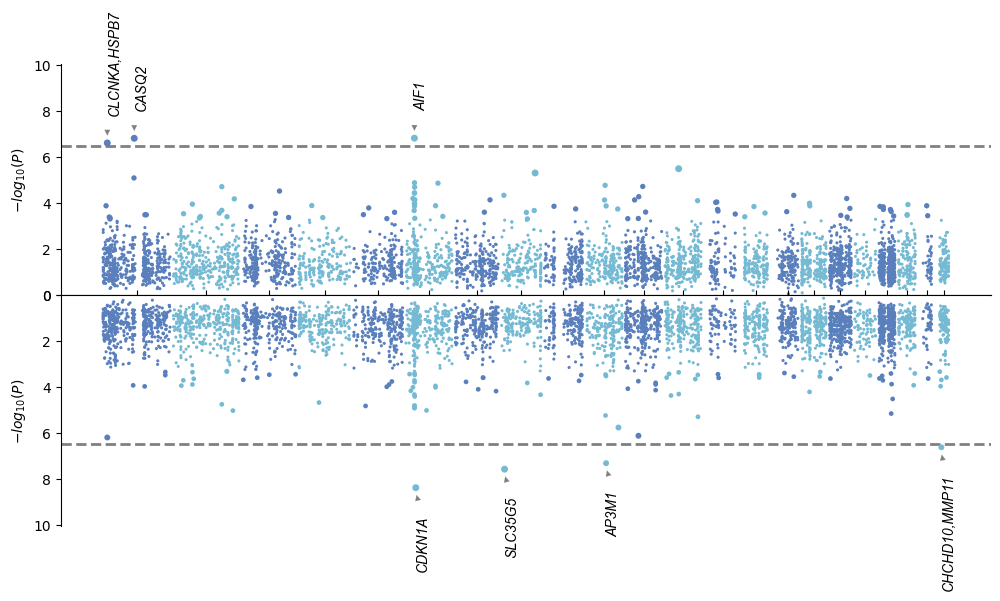

In [20]:
# plot merged aha
annoset_pos = [(int(row['chrom']), row['start']) for i,row in annoset.iterrows()]
fig,_ = gl.plot_miami(path1=twasall[twasall['minsignedP']>0],
                           path2=twasall[twasall['minsignedP']<0],
                           cols1=["chrom","start","minP"],
                           cols2=["chrom","start","minP"],
                        #    titles=["Up regulated","Down regulated"],
                           titles_pad=[0.15,0.0],
                           anno='GENENAME',
                           anno_set=annoset_pos,region_hspace=0,
                           figargs= {"figsize":(12,6)}, build="19",  sig_level=siglevel, anno_style="tight",
                           )
# fig.tight_layout()
fig.savefig(f'/Users/clu/git/3D_cardiac_GWAS/the_paper/data/png/twas_{trait}manhattan.pdf')